In [1]:
import pandas as pd
import torch
import torch.cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from vocabulary import Vocabulary
from torch.optim import Adam
import os
import numpy as np
# import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
# import input_model
from statistics import mean
from sklearn import metrics




/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## build regression model

### 1. VRC01

In [21]:
data = pd.read_csv('./data/processed_data2/VRC01.csv')

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.ali_sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [22]:
vocabulary.vocabulary

{'M': 14,
 'R': 18,
 'V': 21,
 'K': 12,
 'G': 9,
 '-': 3,
 'I': 11,
 'L': 13,
 'N': 15,
 'Y': 23,
 'Q': 17,
 'W': 22,
 'S': 19,
 'F': 8,
 'C': 5,
 'T': 20,
 'P': 16,
 'E': 7,
 'A': 4,
 'D': 6,
 'H': 10,
 '*': 2,
 '#': 1,
 '<pad>': 0,
 '<start>': 24,
 '<end>': 25}

In [23]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 25
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [24]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.ali_sequence.values
        eval_data = df_eval.ali_sequence.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 1039)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [25]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [26]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [27]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input.shape)
    print(target)
    break

0
torch.Size([32, 1039])
tensor([2.8200e-02, 2.0000e-01, 1.9900e+00, 1.0000e+02, 1.1100e-01, 1.4000e-01,
        5.0500e-01, 1.3910e-01, 2.0300e-02, 5.2600e-02, 1.0000e+02, 3.7887e+01,
        2.1080e-01, 7.2500e-02, 5.0000e-02, 8.0000e-01, 6.0000e-02, 9.9800e-01,
        8.0000e-02, 1.2490e-01, 4.9750e-01, 1.0000e-01, 4.1000e-01, 7.1250e-01,
        1.4000e+00, 3.2700e-01, 1.8889e+01, 3.5240e+00, 4.9900e-01, 3.2400e-02,
        1.2400e-01, 5.3000e-01])


In [29]:
# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        # Embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Transformer编码器
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # Transformer编码器
        x = self.encoder(x)
        
        # 平均池化
        x = torch.mean(x, dim=1)
        
        # 输出层
        x = self.output_layer(x)
        return x



In [30]:
# 设置超参数
input_size = len(vocabulary.vocabulary)  # 输入序列的词汇大小
output_size = 1  # 输出的数值大小
hidden_size = 256  # 隐藏层大小
num_layers = 4  # Transformer编码器的层数
num_heads = 8  # 注意力头的数量
dropout = 0.1  # Dropout率
batch_size = 32  # 批处理大小
num_epochs = 300  # 训练轮数
learning_rate = 0.01  # 学习率


In [31]:
# 创建模型和优化器
model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
if os.path.exists("./model/pickles/model_VCR01.pkl"):
    model.load_state_dict(torch.load("./model/pickles/model_VCR01.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_VCR01.pkl"))



In [32]:
# 训练模型
loss_item = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        if index%100 == 0:
            torch.save(model.state_dict(), "./model/pickles/model_VRC01.pkl")
            torch.save(optimizer.state_dict(), "./model/pickles/optimizer_VRC01.pkl")
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第1个epoch, mean_loss:1312.21
第2个epoch, mean_loss:1297.09
第3个epoch, mean_loss:1290.15
第4个epoch, mean_loss:1292.32
第5个epoch, mean_loss:1290.05
第6个epoch, mean_loss:1286.6
第7个epoch, mean_loss:1285.47
第8个epoch, mean_loss:1292.52
第9个epoch, mean_loss:1282.04
第10个epoch, mean_loss:1288.02
第11个epoch, mean_loss:1286.39
第12个epoch, mean_loss:1289.83
第13个epoch, mean_loss:1287.32
第14个epoch, mean_loss:1285.43
第15个epoch, mean_loss:1284.13
第16个epoch, mean_loss:1290.77
第17个epoch, mean_loss:1291.64
第18个epoch, mean_loss:1293.07
第19个epoch, mean_loss:1295.87
第20个epoch, mean_loss:1294.83
第21个epoch, mean_loss:1285.37
第22个epoch, mean_loss:1286.69
第23个epoch, mean_loss:1285.3
第24个epoch, mean_loss:1290.09
第25个epoch, mean_loss:1288.67
第26个epoch, mean_loss:1287.99
第27个epoch, mean_loss:1287.2
第28个epoch, mean_loss:1283.56
第29个epoch, mean_loss:1290.82
第30个epoch, mean_loss:1283.22
第31个epoch, mean_loss:1280.99
第32个epoch, mean_loss:1284.29
第33个epoch, mean_loss:1285.25
第34个epoch, mean_loss:1286.6
第35个epoch, mean_loss:1294.4

KeyboardInterrupt: 

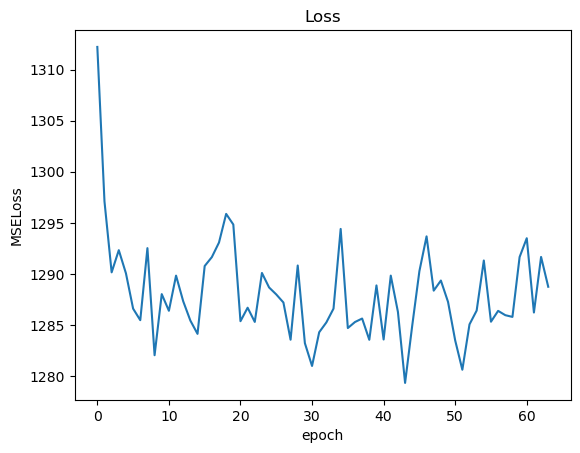

In [33]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()

In [15]:
#  模型评估 RMSE和R2
RMSE = []
R2 = []

if os.path.exists("./model/pickles/model_VCR01.pkl"):
    model.load_state_dict(torch.load("./model/pickles/model_VCR01.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_VCR01.pkl"))
else:
    print("Can not find this model!!!!")



### 2F5

In [3]:
name = "2F5"
data = pd.read_csv('./data/antibody/processed_data/{}.csv'.format(name))

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [4]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [5]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.sequence.values
        eval_data = df_eval.sequence.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 1041)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [6]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [7]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [8]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input.shape)
    print(target)
    break

0
torch.Size([32, 1041])
tensor([  0.2000,   1.3200,  12.9000,   4.3000,  50.0000,  50.0000, 100.0000,
         50.0000, 100.0000,  50.0000,   1.0720, 100.0000,  50.0000,   3.5900,
          1.9850, 100.0000,  50.0000,   9.0920, 100.0000,   3.8100, 100.0000,
        100.0000, 100.0000, 100.0000, 100.0000,  50.0000,  50.0000,   1.4700,
          3.2900, 100.0000, 100.0000, 100.0000])


In [9]:
# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        # Embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Transformer编码器
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # Transformer编码器
        x = self.encoder(x)
        
        # 平均池化
        x = torch.mean(x, dim=1)
        
        # 输出层
        x = self.output_layer(x)
        return x



In [10]:
# 设置超参数
input_size = len(vocabulary.vocabulary)  # 输入序列的词汇大小
output_size = 1  # 输出的数值大小
hidden_size = 256  # 隐藏层大小
num_layers = 4  # Transformer编码器的层数
num_heads = 8  # 注意力头的数量
dropout = 0.1  # Dropout率
batch_size = 32  # 批处理大小
num_epochs = 300  # 训练轮数
learning_rate = 0.01  # 学习率


In [11]:
# 创建模型和优化器
model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
if os.path.exists("./model/pickles/model_{}.pkl".format(name)):
    model.load_state_dict(torch.load("./model/pickles/model_{}.pkl".format(name)))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_{}.pkl".format(name)))



In [14]:
# 训练模型
loss_item = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        if index%100 == 0:
            torch.save(model.state_dict(), "./model/pickles/model_{}.pkl".format(name))
            torch.save(optimizer.state_dict(), "./model/pickles/optimizer_{}.pkl".format(name))
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第1个epoch, mean_loss:2300.42
第2个epoch, mean_loss:1877.81
第3个epoch, mean_loss:1883.76
第4个epoch, mean_loss:1860.41
第5个epoch, mean_loss:1863.05
第6个epoch, mean_loss:1852.95
第7个epoch, mean_loss:1867.0
第8个epoch, mean_loss:1862.74
第9个epoch, mean_loss:1860.97
第10个epoch, mean_loss:1852.17
第11个epoch, mean_loss:1866.92
第12个epoch, mean_loss:1856.63
第13个epoch, mean_loss:1853.04
第14个epoch, mean_loss:1861.59
第15个epoch, mean_loss:1864.83
第16个epoch, mean_loss:1857.57
第17个epoch, mean_loss:1854.56
第18个epoch, mean_loss:1871.73
第19个epoch, mean_loss:1880.6
第20个epoch, mean_loss:1863.15
第21个epoch, mean_loss:1853.6
第22个epoch, mean_loss:1859.71
第23个epoch, mean_loss:1863.48
第24个epoch, mean_loss:1865.02
第25个epoch, mean_loss:1858.58
第26个epoch, mean_loss:1864.39
第27个epoch, mean_loss:1876.28
第28个epoch, mean_loss:1853.14
第29个epoch, mean_loss:1854.22
第30个epoch, mean_loss:1861.94
第31个epoch, mean_loss:1867.32
第32个epoch, mean_loss:1857.47
第33个epoch, mean_loss:1869.75
第34个epoch, mean_loss:1857.5
第35个epoch, mean_loss:1861.7

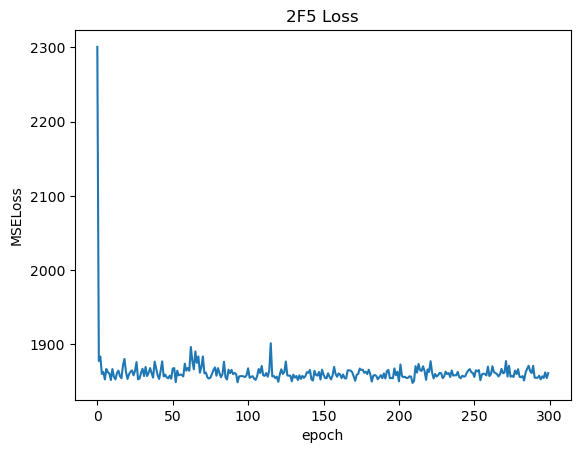

In [15]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("{} Loss".format(name))
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()

In [16]:
#  模型评估 RMSE和R2
RMSE = []
R2 = []

if os.path.exists("./model/pickles/model_{}.pkl".format(name)):
    model.load_state_dict(torch.load("./model/pickles/model_{}.pkl".format(name)))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_{}.pkl".format(name)))
else:
    print("Can not find this model!!!!")



### 2G12

In [17]:
name = "2G12"
data = pd.read_csv('./data/antibody/processed_data/{}.csv'.format(name))

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [18]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [19]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.sequence.values
        eval_data = df_eval.sequence.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 1041)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [20]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [21]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [22]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input.shape)
    print(target)
    break

0
torch.Size([32, 1041])
tensor([100.0000, 100.0000,  20.0000, 100.0000,   0.1110,  50.0000, 100.0000,
        100.0000,   2.1000, 100.0000, 100.0000,  50.0000, 100.0000, 100.0000,
        100.0000, 100.0000,   2.9000, 100.0000, 100.0000, 100.0000,   4.6230,
         50.0000,  50.0000, 100.0000, 100.0000,   0.5000,   0.1540, 100.0000,
        100.0000,  50.0000, 100.0000,  50.0000])


In [23]:
# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        # Embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Transformer编码器
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # Transformer编码器
        x = self.encoder(x)
        
        # 平均池化
        x = torch.mean(x, dim=1)
        
        # 输出层
        x = self.output_layer(x)
        return x



In [24]:
# 设置超参数
input_size = len(vocabulary.vocabulary)  # 输入序列的词汇大小
output_size = 1  # 输出的数值大小
hidden_size = 256  # 隐藏层大小
num_layers = 4  # Transformer编码器的层数
num_heads = 8  # 注意力头的数量
dropout = 0.1  # Dropout率
batch_size = 32  # 批处理大小
num_epochs = 300  # 训练轮数
learning_rate = 0.01  # 学习率


In [25]:
# 创建模型和优化器
model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
if os.path.exists("./model/pickles/model_{}.pkl".format(name)):
    model.load_state_dict(torch.load("./model/pickles/model_{}.pkl".format(name)))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_{}.pkl".format(name)))



In [26]:
# 训练模型
loss_item = []
for epoch in range(num_epochs):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        if index%100 == 0:
            torch.save(model.state_dict(), "./model/pickles/model_{}.pkl".format(name))
            torch.save(optimizer.state_dict(), "./model/pickles/optimizer_{}.pkl".format(name))
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第1个epoch, mean_loss:2769.74
第2个epoch, mean_loss:1630.16
第3个epoch, mean_loss:1606.36
第4个epoch, mean_loss:1592.99
第5个epoch, mean_loss:1606.82
第6个epoch, mean_loss:1613.02
第7个epoch, mean_loss:1570.87
第8个epoch, mean_loss:1639.48
第9个epoch, mean_loss:1609.49
第10个epoch, mean_loss:1603.05
第11个epoch, mean_loss:1568.29
第12个epoch, mean_loss:1616.22
第13个epoch, mean_loss:1587.97
第14个epoch, mean_loss:1592.46
第15个epoch, mean_loss:1598.05
第16个epoch, mean_loss:1633.53
第17个epoch, mean_loss:1618.1
第18个epoch, mean_loss:1612.43
第19个epoch, mean_loss:1583.15
第20个epoch, mean_loss:1634.73
第21个epoch, mean_loss:1598.21
第22个epoch, mean_loss:1606.11
第23个epoch, mean_loss:1610.1
第24个epoch, mean_loss:1624.15
第25个epoch, mean_loss:1588.56
第26个epoch, mean_loss:1585.77
第27个epoch, mean_loss:1615.01
第28个epoch, mean_loss:1589.23
第29个epoch, mean_loss:1611.21
第30个epoch, mean_loss:1579.0
第31个epoch, mean_loss:1600.52
第32个epoch, mean_loss:1617.84
第33个epoch, mean_loss:1587.28
第34个epoch, mean_loss:1613.46
第35个epoch, mean_loss:1588.

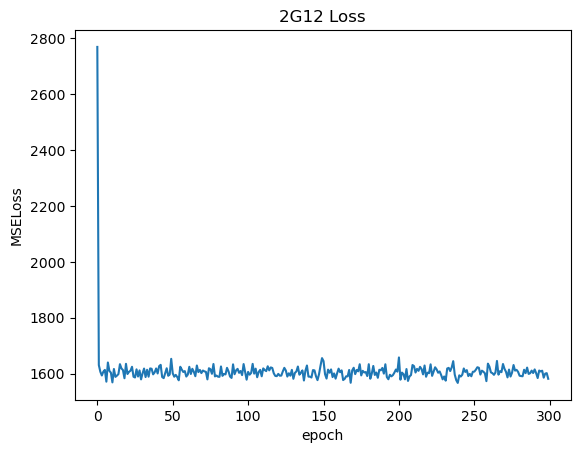

In [27]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("{} Loss".format(name))
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()

In [28]:
#  模型评估 RMSE和R2
RMSE = []
R2 = []

if os.path.exists("./model/pickles/model_{}.pkl".format(name)):
    model.load_state_dict(torch.load("./model/pickles/model_{}.pkl".format(name)))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer_{}.pkl".format(name)))
else:
    print("Can not find this model!!!!")

